In [1]:
## Import libraries

# taxi and weather data import
from utils import get_taxi_data
from meteostat import Point, Daily, Stations

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas

# numerical operations
import pandas as pd
import numpy as np

# data handling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

## Configuration
pd.set_option("display.precision", 3)
%matplotlib inline

In [2]:
def import_taxi_zones(path,borough_name):
    
    # import taxi zones from NYC Taxi & Limousine Commision, and set index
    zones = geopandas.read_file(path)
    zones = zones.set_index('OBJECTID')
    zones.index.rename("grid",inplace=True)
    
    # change coordinate reference system to New York specific
    # source: https://epsg.io/?q=new+york
    zones.to_crs('EPSG:32118')

    # save zones within Manhattan
    borough = zones.loc[zones.borough.str.contains(borough_name)]
    
    return zones, borough

In [3]:
def clean_data(df,month,year,borough):
    
    # drop data for pick-ups outside selected borough
    df.drop(df[~df.PULocationID.isin(borough)].index, inplace=True)
    
    # remove data points where pick-up date is not in desired month
    df.drop(df.loc[df.tpep_pickup_datetime.dt.month != int(month)].index,inplace=True)

    # remove data points where pick-up date is not in desired year
    df.drop(df.loc[df.tpep_pickup_datetime.dt.year != int(year)].index,inplace=True)
    
    # drop any data where pick-up or drop-off LocationID is 264 or 265, as they are equivalent to NaN values
    df.drop(df.loc[(df.PULocationID==264)|(df.PULocationID==265)].index,inplace=True)
    
    # drop any data with negative fare_amount
    df.drop(df.loc[df.fare_amount < 0].index,inplace=True)

    # drop any data beyond 99th percentile of fare_amount
    df.drop(df.loc[df.fare_amount > df.fare_amount.quantile(0.99)].index,inplace=True)
    
    return df

In [4]:
def daily_taxi_summary(df):
    
    # add day of month and month as a columns to classify data by day and month
    df.insert(1,'day',df.tpep_pickup_datetime.dt.day)
    df.insert(1,'month',df.tpep_pickup_datetime.dt.month)

    # find daily number of pickups for each city grid
    daily_demand = df.groupby(['day']).PULocationID.value_counts().rename('demand').to_frame()

    # find monthly median number of pickups for each city grid
    median_demand = daily_demand.groupby('PULocationID').median().rename(columns={'demand':'median_demand'})

    # find median daily fare amount for each city grid where the passenger was picked up
    median_fare = df.groupby(['day','PULocationID']).fare_amount.median().rename('median_fare').to_frame()

    # merge demand and median fare dataframes
    daily_summary = daily_demand.merge(median_fare,how='left',left_index=True,right_index=True,validate='one_to_one')

    # merge median demand onto daily summary dataframe
    daily_summary = daily_summary.merge(median_demand,how='left',left_index=True,right_index=True,validate='one_to_one')
    
    # add pick up grid index to dataframe
    daily_summary['grid'] = daily_summary.index.to_frame().iloc[:,1]
    
    # find unique dates in dataframe and convert to datetime format
    dates = pd.DataFrame(df.tpep_pickup_datetime.dt.date.unique(),columns=['date'],dtype='datetime64[s]')
    dates.index = dates.date.dt.day
    
    # add dates to daily summary, and convert to datetime format
    daily_summary = daily_summary.merge(dates,left_on='day',right_index=True,validate='many_to_one')
    
    # add calendar features to dataframe
    daily_summary['weekday'] = daily_summary.date.dt.weekday
    daily_summary['month'] = daily_summary.date.dt.month
    daily_summary['quarter'] = daily_summary.date.dt.quarter
    
    # reindex to default, dropping previous indices
    daily_summary.reset_index(drop=True,inplace=True)
    
    return daily_summary

In [5]:
def get_weather_data(df,borough):
    
    # instantiate empty dataframe for weather data
    weather = pd.DataFrame()
    
    # obtain daily weather data for each city grid
    for grid in df.grid.unique():
        
        # define start and end times for weather query
        start_time = df.loc[df.grid == grid].date.min().to_pydatetime()
        end_time = df.loc[df.grid == grid].date.max().to_pydatetime()
        
        # find the centroid of city grid
        centroid = borough.to_crs('EPSG:4326').loc[grid].geometry.centroid

        # define Meteostat Point at the centroid coordinates
        point = Point(lon=centroid.x,lat=centroid.y)

        # obtain grid weather data from weather station nearest to point using Meteostat Daily API
        query = Daily(point,start_time,end_time)
        grid_weather = query.fetch()
        
        # fill NaN values in wind direction and air pressure columns with zero
        grid_weather.wdir.fillna(0,inplace=True)
        grid_weather.pres.fillna(0,inplace=True)
        
        # add grid number and date to grid weather data
        grid_weather.insert(0,'grid',grid)
        grid_weather.insert(0,'date',grid_weather.index.to_frame())
        
        # concatenate grid weather dataframe onto weather dataframe
        weather = pd.concat([weather,grid_weather],axis=0,ignore_index=True)
    
    # drop tsun columns as it is incomplete for 2018 data
    weather.drop(columns='tsun',inplace=True)
    
    # drop columns where all values are NaN
    weather.dropna(axis=1,how='all',inplace=True)
        
    return weather

In [6]:
def process_data(year,months,columns,vehicle,path,verbose=False):

    # instantiate empty dataframe to fill with processed data
    processed_df = pd.DataFrame()

    # iterate over multiple months
    for m in months:
        
        # print progress if verbose
        print(f"Importing data for month {m}")
        
        # convert month to two-digit format 
        if m > 9:
            month = f"{m}"
        else:
            month = f"0{m}"

        # import the taxi data with specified arguments
        raw_df = get_taxi_data(year, month, vehicles=vehicle, columns=columns, save=True, localpath=path)

        # clean data frame for given year and month, with pickup locations restricted to Manhattan
        clean_df = clean_data(raw_df,month,year,manhattan.index)

        # summarise daily taxi dataframe
        taxi_df = daily_taxi_summary(clean_df)

        # obtain daily weather dataframe
        weather_df = get_weather_data(taxi_df,manhattan)

        # merge taxi and weather dataframes
        daily_df = taxi_df.merge(weather_df,on=['date','grid'],how='inner',validate='one_to_one')

        # concatenate daily dataframe onto processed dataframe
        processed_df = pd.concat([processed_df,daily_df],axis=0,ignore_index=True)

    # show memory usage statistics and verify no NaN values
    print(processed_df.info(memory_usage='deep'))

    return processed_df

In [9]:
# import taxi zones data
path = 'data/taxi_zones/taxi_zones.shp'
zones, manhattan = import_taxi_zones(path,'Manhattan')

# taxi data import arguments
columns = ['tpep_pickup_datetime','fare_amount','PULocationID','DOLocationID']
year = '2018'
months = range(1,13)
vehicle = 'yellow'
path = '~/Documents/PythonProject/data/taxi_data/'

# import and process the desired data frame
processed_df = process_data(year,months,columns,vehicle,path)

In [8]:
def train_decision_tree_regressor(X_data,y_data,max_depth,verbose=False):
    
    # split data into 80% training data and 20% testing data
    X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.2, random_state=14)
    
    # instantiate the decision tree regressor
    regr = DecisionTreeRegressor(max_depth=max_depth,random_state=7)
    
    # fit training data to the regressor
    regr.fit(X_train,y_train)
    
    # print statistics if verbose
    if verbose:
        # score the training fit with coefficient of determination
        print(f"Training R^2: {regr.score(X_train,y_train):.3f}")

        # score the regressors ability to predict testing data with coefficient of determination
        print(f"Testing R^2: {regr.score(X_test,y_test):.3f}")
    
    return regr

In [9]:
def cross_val_regressor(regr,X_data,y_data,count,verbose=False):
    
    # cross validate regressor 
    cross_scores = pd.Series(cross_val_score(regr, X_data, y_data, cv=count),name='cross_val')
    
    # print statistics if verbose
    if verbose:
        print(f"Cross validation statistics: \n{cross_scores.describe(percentiles=[0.01,0.25,0.75,0.99])}")
        
    return cross_scores

In [10]:
## Train and test a decision tree regressor

# define independent and dependent variables from 2018 data
X_data = processed_df.drop(columns='date').loc[:,'grid':]
y_data = processed_df.demand

# define the maximum depth of the decision tree
max_depth = 14

# train and test the decision tree regressor on the selected data
regr = train_decision_tree_regressor(X_data,y_data,max_depth,verbose=True)

Training R^2: 0.988
Testing R^2: 0.952


In [11]:
## Import validation data that the regressor has not previously seen and cross-validate regressor on this data

# taxi data import arguments
columns = ['tpep_pickup_datetime','fare_amount','PULocationID','DOLocationID']
year = '2019'
months = range(1,13)
vehicle = 'yellow'
path = '~/Documents/PythonProject/data/taxi_data/'

# import and process the desired data frame
validation_df = process_data(year,months,columns,vehicle,path)

# define independent and dependent variables from the validation data of 2019
X_val = validation_df.drop(columns='date').loc[:,'grid':]
y_val = validation_df.demand

# cross validate the decision tree regressor on unseen validation data
cross_val = cross_val_regressor(regr,X_val,y_val,count=100,verbose=True)

Importing data for month 1
Importing data for month 2
Importing data for month 3
Importing data for month 4
Importing data for month 5
Importing data for month 6
Importing data for month 7
Importing data for month 8
Importing data for month 9
Importing data for month 10
Importing data for month 11
Importing data for month 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23996 entries, 0 to 23995
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   demand         23996 non-null  int64         
 1   median_fare    23996 non-null  float64       
 2   median_demand  23996 non-null  float64       
 3   grid           23996 non-null  int64         
 4   date           23996 non-null  datetime64[ns]
 5   weekday        23996 non-null  int64         
 6   month          23996 non-null  int64         
 7   quarter        23996 non-null  int64         
 8   tavg           23996 non-null  float64       
 9 

In [12]:
def max_depth_analysis(regr,X_data,y_data,X_val,y_val,last_depth,verbose=False):
    
    # instantiate cross validation results dataframe
    cv_results = pd.DataFrame()

    # iterate over a range of max_depths for the decision tree and gather cross validation data
    for max_depth in range(1,last_depth+1):

        # train and test decision tree on 2019 data
        regr = train_decision_tree_regressor(X_data,y_data,max_depth)

        # cross validate regression 100 times on 2022 data
        cross_val = cross_val_regressor(regr,X_val,y_val,count=100)

        # insert cross validation scores into results dataframe
        cv_results.insert(loc=0,column=max_depth,value=cross_val)
     
        if verbose:
            # print progress
            print(f"Max Depth: {max_depth}/{last_depth}")
    
    # instantiate max depth against cross validation scores plot
    fig,ax = plt.subplots(figsize=(10,5))

    # define max depths array
    depths = cv_results.columns.to_numpy()

    # calculcate lower and upper quartiles and median of cross validation scores
    q1s = cv_results.quantile(0.25,axis=0)
    medians = cv_results.median(axis=0)
    q3s = cv_results.quantile(0.75,axis=0)

    #plot lower and upper quartiles and median scores against max depths
    ax.plot(depths,q1s,'orangered')
    ax.plot(depths,medians,'steelblue')
    ax.plot(q3s,'seagreen')

    # add plot styling
    ax.legend(['Lower Quartile','Median','Upper Quartile'])
    ax.set_xlabel("Decision Tree Max Depth")
    ax.set_ylabel("Coefficient of Determination")
    ax.set_title("Cross Validation Results for Range of Decision Tree Max Depths")
    ax.set_xlim([0,21])
    ax.set_xticks(range(1,21,2))
    ax.set_ylim([0,1])

    # find maximum median score and at which depth it occurs
    max_median = np.max(medians)
    depth_at_max = depths[np.argmax(medians)]

    # add an arrow annotation where median score is max
    ax.annotate(f"Max median: ({depth_at_max},{max_median:.3f})",xy=(depth_at_max, max_median), xycoords='data',
                xytext=(25, -25), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=90,rad=25"))

    # display plot
    plt.show()

Max Depth: 1/20
Max Depth: 2/20
Max Depth: 3/20
Max Depth: 4/20
Max Depth: 5/20
Max Depth: 6/20
Max Depth: 7/20
Max Depth: 8/20
Max Depth: 9/20
Max Depth: 10/20
Max Depth: 11/20
Max Depth: 12/20
Max Depth: 13/20
Max Depth: 14/20
Max Depth: 15/20
Max Depth: 16/20
Max Depth: 17/20
Max Depth: 18/20
Max Depth: 19/20
Max Depth: 20/20


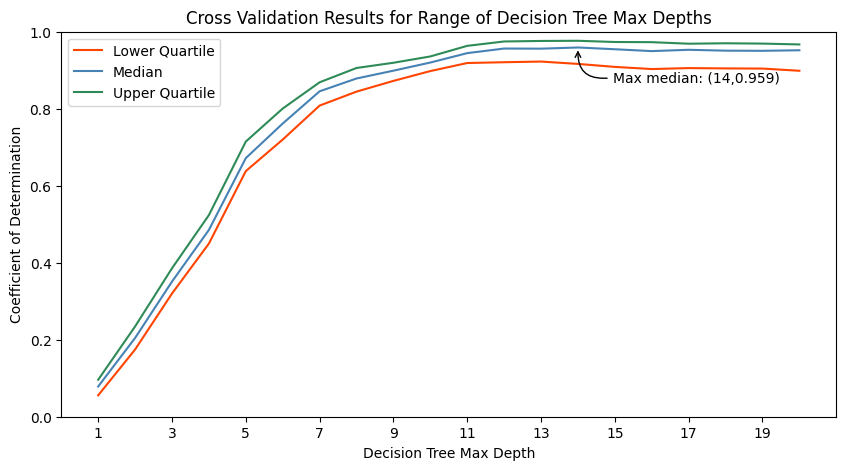

In [13]:
## Perform an analysis of max depth of the decision tree to determine point where model starts to over-fit
max_depth_analysis(regr,X_data,y_data,X_val,y_val,last_depth=20,verbose=True)

In [14]:
def predict_demand(regr,date,borough):

    # instantiate calendar dataframe with grids in desired borough
    calendar_df = pd.DataFrame(borough.index.to_numpy(),columns=['grid'])

    # add calendar elements to calendar dataframe
    calendar_df['date'] = date
    calendar_df['weekday'] = calendar_df.date.dt.weekday
    calendar_df['month'] = calendar_df.date.dt.month
    calendar_df['quarter'] = calendar_df.date.dt.quarter

    # obtain daily weather dataframe
    weather_df = get_weather_data(calendar_df,manhattan)

    # merge taxi and weather dataframes to prediction dataframe
    predict_df = calendar_df.merge(weather_df,on=['date','grid'],how='inner',validate='one_to_one')

    # predict demand using decision tree regressor and add to dataframe
    predict_df.insert(0,column='demand_prediction',value=np.round(regr.predict(predict_df.drop(columns='date')),0))

    # merge borough geometries and zones onto prediction dataframe
    predict_df = predict_df.merge(borough.loc[:,['geometry','zone']],how='left',left_on='grid',right_index=True,validate='one_to_one')
    
    # drop date from dataframe
    predict_df.drop(columns='date',inplace=True)
    
    # set grid to index
    predict_df.index = predict_df.pop('grid')
    
    # change prediction dataframe from pandas to geopandas
    predict_df = geopandas.GeoDataFrame(predict_df,geometry=predict_df.geometry,crs='EPSG:32118')
    
    return predict_df

In [15]:
def inspect_prediction_residuals(regr,X_val,y_val):

    # initialise empty prediction dataframe
    y_val_pred = pd.DataFrame()

    # perform prediction for each date in the X_val dataframe
    for date in X_val.date.unique():

        # predict demand for all grids for given date
        y_pred = pd.DataFrame(regr.predict(X_val.loc[X_val.date==date].drop(columns='date')),columns=['demand_prediction'])

        # add date and grid as columns
        y_pred['grid'] = X_val.loc[X_val.date==date].grid.reset_index(drop=True)
        y_pred['date'] = date

        # set date and grid as a multi-index
        y_pred.set_index(['date','grid'],drop=True,inplace=True)

        # concatenate prediction
        y_val_pred = pd.concat([y_val_pred,y_pred],axis=0)

    # calculate the residuals as observed minus predicted demand
    residuals = y_val.demand.sub(y_val_pred.demand_prediction,axis=0).abs()

    # instantiate plot
    fig,ax = plt.subplots(figsize=(10,5))

    # find median residuals for predictions and associated dates
    dates = residuals.index.droplevel(1).unique()
    med_residuals = residuals.groupby('date').median()

    # plot median residuals against time
    ax.plot(dates,med_residuals,'steelblue')

    # add plot styling
    ax.set_xlabel("Time [yyyy-mm]")
    ax.set_ylabel("Median residual number of taxi trips")
    ax.set_title("Timeseries of median prediction residuals")

    # find peaks in max residual greater than 1500 trips
    indices = med_residuals[med_residuals > 1500].index
    peak_dates = med_residuals[indices].index.date
    peak_values = med_residuals[indices]
    # peak_values = med_residuals[np.argwhere(med_residuals == )]

    # annotate peak values
    for i in range(len(peak_values)):
        ax.annotate(f"{peak_dates[i]}",xy=(peak_dates[i], peak_values[i]), xycoords='data',
                        xytext=(-80, 0), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->"))

    # display plot
    plt.show()

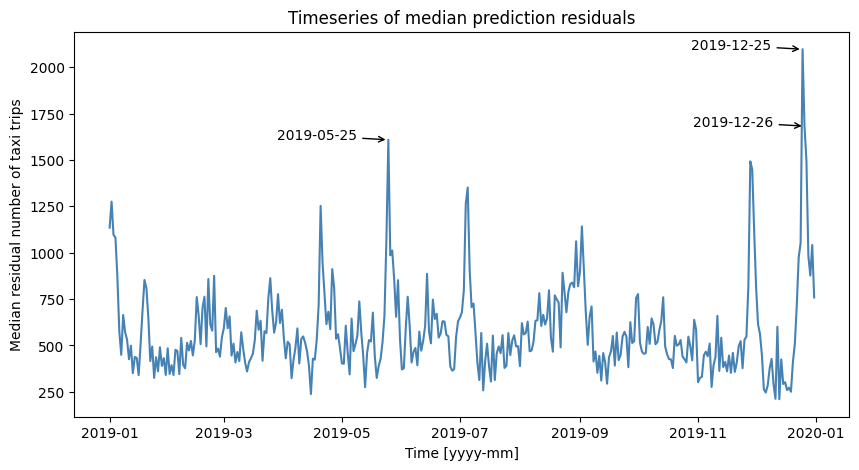

In [16]:
## Investigate prediction residuals over time

# define independent and dependent variables from the validation data of 2019,
# this time without dropping date column
X_val = validation_df.loc[:,'grid':]
y_val = validation_df.loc[:,['date','grid','demand']].set_index(['date','grid'],drop=True)

# define the maximum depth of the decision tree
max_depth = 14

# train and test decision tree on 2018 data
regr = train_decision_tree_regressor(X_data,y_data,max_depth)

# plot max residuals over time
inspect_prediction_residuals(regr,X_val,y_val)

In [17]:
# 2019-05-25 is Memorial Day weekend
# 2019-11-28 is Thanksgiving Day Parade
# 2019-12-25,26 is Christmas celebrations

In [18]:
## Produce a daily prediction for demand and calculate grids with predicted surge demand

# set desired date for prediction
date = np.datetime64("2022-11-18")

# predict demand for desired date
predict_df = predict_demand(regr,date,manhattan)

# calculate median demand per grid in 2019 using validation data
predict_df['demand_median'] = validation_df.groupby('grid').median_demand.median()

# calculate percent difference of predicted demand from median
predict_df['demand_%diff'] = predict_df.demand_prediction.sub(predict_df.demand_median).div(predict_df.demand_median.abs()).mul(100).round(3)

# calculate median fare per grid in 2019 using validation data
predict_df['fare_median'] = validation_df.groupby('grid').median_fare.median()

# calculate surge demand by multiplying percent difference and median fare
predict_df['demand_surge'] = predict_df['demand_%diff'].div(100).mul(predict_df.fare_median).round(2)

In [19]:
predict_df.loc[:,['geometry','zone','demand_prediction','demand_median','demand_%diff','fare_median','demand_surge']].explore('demand_%diff')